In [4]:
import os
import pandas as pd
from google.cloud import bigquery
from bq_helper import BigQueryHelper

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.max_rows = 20
%matplotlib inline
sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )
# sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'AppleGothic'} )

In [3]:
def toReadable(v):
    value = round(v,2) if isinstance(v, float) else v

    if value < 1000:
        return str(value)
    elif value<1000000:
        return str(round(value/1000,1))+'K'
    elif value>=1000000:
        return str(round(value/1000000,1))+'M'
    return value

In [3]:
raw_order_ds = pd.read_csv('./data/orders.csv')
order_product_ds = pd.read_csv('./data/order_products__prior.csv')
product_ds = pd.read_csv('./data/products.csv')

order_product_cnt_ds = order_product_ds.groupby('order_id').count()[['product_id']]
order_product_cnt_ds.columns = ['product_cnt']

## join product count 
order_ds = raw_order_ds.merge(order_product_cnt_ds, left_on='order_id', right_index=True)

In [42]:
raw_order_ds.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [43]:
order_product_ds.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [44]:
product_ds.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [45]:
order_product_cnt_ds.head()

,product_cnt
order_id,
2,9
3,8
4,13
5,26
6,3


In [47]:
order_ds.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_cnt
0,2539329,1,prior,1,2,8,NaN,5
1,2398795,1,prior,2,3,7,15.0,6
2,473747,1,prior,3,3,12,21.0,5
3,2254736,1,prior,4,4,7,29.0,5
4,431534,1,prior,5,4,15,28.0,8
5,3367565,1,prior,6,2,7,19.0,4
6,550135,1,prior,7,1,9,20.0,5
7,3108588,1,prior,8,1,14,14.0,6
8,2295261,1,prior,9,1,16,0.0,6
9,2550362,1,prior,10,4,8,30.0,9


In [5]:
total_user = len(order_ds.user_id.unique())
total_order = len(order_ds)
total_ordered_product = len(order_product_ds)
unique_products = len(order_product_ds.product_id.unique())

print("total user = {}".format(toReadable(total_user)))
print("total order = {} ({} orders per a user )".format(toReadable(total_order), toReadable(total_order/total_user) ))
print("total product = ", toReadable(unique_products))
print("total ordered product  = {} ({} orders per a product )".format(
    toReadable(total_ordered_product), toReadable(total_ordered_product/unique_products) ))

total user = 206.2K
total order = 3.2M (15.59 orders per a user )
total product =  49.7K
total ordered product  = 32.4M (652.91 orders per a product )


In [57]:
"""
Clustering similar product by user's order information
Traing product2vec using word2vec

word = product_id
sentence = user's order = [product_id1, product_id2, ... ]

clustering by trained product vector
Use only products ordered more than 200 times

"""

"\nClustering similar product by user's order information\nTraing product2vec using word2vec\n\nword = product_id\nsentence = user's order = [product_id1, product_id2, ... ]\n\nclustering by trained product vector\nUse only products ordered more than 200 times\n\n"

In [48]:
merge_order_product_ds = order_product_ds.merge(order_ds, on='order_id' )

In [49]:
# create list of order_ids and their product_ids
order_product_list = merge_order_product_ds\
    .sort_values(['user_id','order_id','add_to_cart_order'])[['order_id','product_id']]\
    .values.tolist()


product_corpus = []
sentence = []

new_order_id = order_product_list[0][0]
for (order_id, product_id) in order_product_list:
    if new_order_id != order_id:
        product_corpus.append(sentence)
        sentence = []
        new_order_id = order_id
    sentence.append(str(product_id))

In [51]:
order_product_list[0:10] #list of order_ids and their product_ids

[[431534, 196],
 [431534, 12427],
 [431534, 10258],
 [431534, 25133],
 [431534, 10326],
 [431534, 17122],
 [431534, 41787],
 [431534, 13176],
 [473747, 196],
 [473747, 12427]]

In [56]:
product_corpus[2]

['196', '10258', '12427', '25133', '13032']

In [15]:
from gensim.models import Word2Vec

model = Word2Vec(product_corpus, window=6, size=100, workers=4, min_count=200)
# model.save('./resource/prod2vec.100d.model')
# model = Word2Vec.load('./resource/prod2vec.100d.model')

In [16]:
def toProductName(id):
    return product_ds[product_ds.product_id==id]['product_name'].values.tolist()[0]
toProductName(24852)

'Banana'

In [17]:
def most_similar_readable(model, product_id):
    
    similar_list = [(product_id,1.0)]+model.wv.most_similar(str(product_id))
    return [( toProductName(int(id)), similarity ) for (id,similarity) in similar_list]

In [18]:
pd.DataFrame(most_similar_readable(model, 24852), columns=['product','similarity'])

,product,similarity
0,Banana,1.000000
1,Bag of Organic Bananas,0.697643
2,Bartlett Pears,0.588276
3,Seedless Red Grapes,0.580675
4,XL Emerald White Seedless Grapes,0.529617
5,Total 0% Greek Yogurt,0.525475
6,Organic Banana,0.517278
7,Organic Fuji Apple,0.514741
8,Granny Smith Apples,0.511650
9,Total 2% All Natural Plain Greek Yogurt,0.483800


In [20]:
pd.DataFrame(most_similar_readable(model, 27845), columns=['product','similarity'])

,product,similarity
0,Organic Whole Milk,1.000000
1,Organic Reduced Fat Milk,0.770823
2,Organic Lowfat 1% Milk,0.705899
3,Whole Organic Omega 3 Milk,0.693397
4,Organic Lactose Free Whole Milk,0.652165
5,Organic Mini Homestyle Waffles,0.614940
6,1% Lowfat Milk,0.611600
7,Organic Whole Grassmilk Milk,0.609873
8,Organic Multigrain Waffles,0.598374
9,Organic Whole String Cheese,0.595686


In [21]:
pd.DataFrame(most_similar_readable(model, 40939), columns=['product','similarity'])

,product,similarity
0,Drinking Water,1.000000
1,Foam Bowls,0.756158
2,Nacho Cheese Flavored Tortilla Chips,0.754436
3,Organic 2% Milk,0.747239
4,Boneless & Skinless Chicken Breasts,0.742800
5,Tea,0.730150
6,Diet,0.727168
7,First Aid Antibiotic Ointment,0.725483
8,"100% Juice, Variety Pack",0.724873
9,Margarine,0.723116


In [22]:
pd.DataFrame(most_similar_readable(model, 48697), columns=['product','similarity'])

,product,similarity
0,Canola Oil,1.000000
1,Light Brown Sugar,0.761089
2,Unsalted Butter,0.738221
3,Corn Starch,0.736623
4,Whole Wheat Flour,0.708731
5,Panko Bread Crumbs,0.706333
6,Unbleached Bread Flour,0.701377
7,Refined Canola Oil,0.691772
8,Active Dry Yeast,0.690130
9,Unbleached All-Purpose Flour,0.685767


In [23]:
from __future__ import division
import random
import numpy as np
from scipy.spatial.distance import cdist  # $scipy/spatial/distance.py
    # http://docs.scipy.org/doc/scipy/reference/spatial.html
from scipy.sparse import issparse  # $scipy/sparse/csr.py

__date__ = "2011-11-17 Nov denis"
    # X sparse, any cdist metric: real app ?
    # centres get dense rapidly, metrics in high dim hit distance whiteout
    # vs unsupervised / semi-supervised svm
#...............................................................................
def kmeans( X, centres, delta=.001, maxiter=10, metric="euclidean", p=2, verbose=1 ):
    """ centres, Xtocentre, distances = kmeans( X, initial centres ... )
    in:
        X N x dim  may be sparse
        centres k x dim: initial centres, e.g. random.sample( X, k )
        delta: relative error, iterate until the average distance to centres
            is within delta of the previous average distance
        maxiter
        metric: any of the 20-odd in scipy.spatial.distance
            "chebyshev" = max, "cityblock" = L1, "minkowski" with p=
            or a function( Xvec, centrevec ), e.g. Lqmetric below
        p: for minkowski metric -- local mod cdist for 0 < p < 1 too
        verbose: 0 silent, 2 prints running distances
    out:
        centres, k x dim
        Xtocentre: each X -> its nearest centre, ints N -> k
        distances, N
    see also: kmeanssample below, class Kmeans below.
    """
    if not issparse(X):
        X = np.asanyarray(X)  # ?
    centres = centres.todense() if issparse(centres) \
        else centres.copy()
    N, dim = X.shape
    k, cdim = centres.shape
    if dim != cdim:
        raise ValueError( "kmeans: X %s and centres %s must have the same number of columns" % (
            X.shape, centres.shape ))
    if verbose:
        print ("kmeans: X %s  centres %s  delta=%.2g  maxiter=%d  metric=%s" % (
            X.shape, centres.shape, delta, maxiter, metric) )
    allx = np.arange(N)
    prevdist = 0
    for jiter in range( 1, maxiter+1 ):
        D = cdist_sparse( X, centres, metric=metric, p=p )  # |X| x |centres|
        xtoc = D.argmin(axis=1)  # X -> nearest centre
        distances = D[allx,xtoc]
        avdist = distances.mean()  # median ?
        if verbose >= 2:
            print("kmeans: av |X - nearest centre| = %.4g" % avdist)
        if (1 - delta) * prevdist <= avdist <= prevdist \
        or jiter == maxiter:
            break
        prevdist = avdist
        for jc in range(k):  # (1 pass in C)
            c = np.where( xtoc == jc )[0]
            if len(c) > 0:
                centres[jc] = X[c].mean( axis=0 )
    if verbose:
        print ("kmeans: %d iterations  cluster sizes:" % jiter, np.bincount(xtoc))
    if verbose >= 2:
        r50 = np.zeros(k)
        r90 = np.zeros(k)
        for j in range(k):
            dist = distances[ xtoc == j ]
            if len(dist) > 0:
                r50[j], r90[j] = np.percentile( dist, (50, 90) )
        print ("kmeans: cluster 50 % radius", r50.astype(int))
        print ("kmeans: cluster 90 % radius", r90.astype(int))
            # scale L1 / dim, L2 / sqrt(dim) ?
    return centres, xtoc, distances
#...............................................................................
def kmeanssample( X, k, nsample=0, **kwargs ):
    """ 2-pass kmeans, fast for large N:
        1) kmeans a random sample of nsample ~ sqrt(N) from X
        2) full kmeans, starting from those centres
    """
        # merge w kmeans ? mttiw
        # v large N: sample N^1/2, N^1/2 of that
        # seed like sklearn ?
    N, dim = X.shape
    if nsample == 0:
        nsample = max( 2*np.sqrt(N), 10*k )
    Xsample = randomsample( X, int(nsample) )
    pass1centres = randomsample( X, int(k) )
    samplecentres = kmeans( Xsample, pass1centres, **kwargs )[0]
    return kmeans( X, samplecentres, **kwargs )

def cdist_sparse( X, Y, **kwargs ):
    """ -> |X| x |Y| cdist array, any cdist metric
        X or Y may be sparse -- best csr
    """
        # todense row at a time, v slow if both v sparse
    sxy = 2*issparse(X) + issparse(Y)
    if sxy == 0:
        return cdist( X, Y, **kwargs )
    d = np.empty( (X.shape[0], Y.shape[0]), np.float64 )
    if sxy == 2:
        for j, x in enumerate(X):
            d[j] = cdist( x.todense(), Y, **kwargs ) [0]
    elif sxy == 1:
        for k, y in enumerate(Y):
            d[:,k] = cdist( X, y.todense(), **kwargs ) [0]
    else:
        for j, x in enumerate(X):
            for k, y in enumerate(Y):
                d[j,k] = cdist( x.todense(), y.todense(), **kwargs ) [0]
    return d

def randomsample( X, n ):
    """ random.sample of the rows of X
        X may be sparse -- best csr
    """
    random.seed(100)    
    sampleix = random.sample( range( X.shape[0] ), int(n) )
    return X[sampleix]

def nearestcentres( X, centres, metric="euclidean", p=2 ):
    """ each X -> nearest centre, any metric
            euclidean2 (~ withinss) is more sensitive to outliers,
            cityblock (manhattan, L1) less sensitive
    """
    D = cdist( X, centres, metric=metric, p=p )  # |X| x |centres|
    return D.argmin(axis=1)

def Lqmetric( x, y=None, q=.5 ):
    # yes a metric, may increase weight of near matches; see ...
    return (np.abs(x - y) ** q) .mean() if y is not None \
        else (np.abs(x) ** q) .mean()

#...............................................................................
class Kmeans:
    """ km = Kmeans( X, k= or centres=, ... )
        in: either initial centres= for kmeans
            or k= [nsample=] for kmeanssample
        out: km.centres, km.Xtocentre, km.distances
        iterator:
            for jcentre, J in km:
                clustercentre = centres[jcentre]
                J indexes e.g. X[J], classes[J]
    """
    def __init__( self, X, k=0, centres=None, nsample=0, **kwargs ):
        self.X = X
        if centres is None:
            self.centres, self.Xtocentre, self.distances = kmeanssample(
                X, k=k, nsample=nsample, **kwargs )
        else:
            self.centres, self.Xtocentre, self.distances = kmeans(
                X, centres, **kwargs )

    def __iter__(self):
        for jc in range(len(self.centres)):
            yield jc, (self.Xtocentre == jc)

In [24]:
def clustering(model, k=500, delta=0.00000001, maxiter=200):
    movie_vec = model.wv.syn0
    centres, index2cid, dist = kmeanssample(movie_vec, k, 
                                                   metric = 'cosine', 
                                                   delta = delta, 
                                                   nsample = 0, maxiter = maxiter,)
    clustered_ds = pd.DataFrame( [ (a, b, c) for a, b, c in zip(model.wv.index2word, index2cid, dist )],
                 columns=['product_id', 'cid', 'dist'] ).sort_values(['cid','dist'], ascending=True)

    prod2cid = { product_id:cid for product_id,cid in zip(model.wv.index2word, index2cid) }

    return (centres, index2cid, dist, clustered_ds, prod2cid)

In [25]:
(centres, index2cid, dist, clustered_ds, prod2cid) = clustering(model)

/anaconda3/envs/ds/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  from ipykernel import kernelapp as app


kmeans: X (5000, 100)  centres (500, 100)  delta=1e-08  maxiter=200  metric=cosine
kmeans: 14 iterations  cluster sizes: [ 6  3 10 13 24 12  9 21 13  1 22  3 13 11 13  6  4 11  1 13  6 14  4  6 16
 13 14 10  5 16 10  9  3  7 20  2 20 11  7 11  9  8 10  5  9 21  5  2 22 11
  2  1  2  7  1 28 11 12  5  2 10  1  6  9  1 24 10  8 10  8  5 22  5 11  3
  9 18 19  5 13  4 10  9 12  7 21 12  3 29  7  5  5 31  9 14 11  6 11 22 10
  9 11 11  7 15 12  7  5 12 24  3 14 25  4  1  1  7  8 18  3  6  8 17 12  4
  5 14  9 18  5 13  6  9 15  6 19 12 13  1 25  8  8 13  7 14  5 16 31  5 13
 19 11 13  8  1 11 10  1 20 36  5  7  5 11 20 25  9 14 10  7  8  9  4  4  5
 11  7  5 14  4  9  5 21  7  8 14  6 16  6  5  9 18  8 16 11 18 16 11 10  7
  7  5 13 16 12  1 23  8 21  2 10 11  7 10  7 20  5  3  9 10  9  6 27  5  7
  1  1 12 17  7  7 11  5  7  7 10  5  7 10  6 10  7  8  6 22  6  6  6  2 10
 13  9 11  7 17 25  4 10 18  7 18 18  6  4  8  9 10 19  6  7 12  2  8  2  4
  8  6 12  3  9 10  3  4  7 13 19  7  1 19 

In [26]:
clustered_ds.product_id = clustered_ds.product_id.apply(pd.to_numeric)

In [27]:
def idToProductDesc(id):
    return product_ds[product_ds.product_id==id][['product_name','aisle_id']].values.tolist()[0]
    
def getProductNames(product_id_list):
    return [ idToProductDesc(int(product_id)) for  product_id in product_id_list ]

import urllib
def printClusterMembers(cluster_id, topn=10):
    members = getProductNames(clustered_ds[clustered_ds.cid==cluster_id].product_id[:topn].tolist())
    for member in members:
        print("{aisle} / {name} ".format( 
            aisle=member[1], name=member[0], q=urllib.parse.quote_plus(member[0]) ) 
        )

In [28]:
printClusterMembers(1, topn=10)

78 / Cranberry Raincoast Oat Crisps 
117 / Shelled & Dry Roasted Organic Pistachios 
78 / Rosemary Raisin Raincoast Oat Crisps 
117 / Sea Salt Macadamias 
120 / Mediterranean Style Kefir Cheese Labne 
117 / Hazelnuts 


In [29]:
printClusterMembers(100, topn=10)

78 / Baked Vegetable Brown Rice Snaps 
78 / Organic Brown Rice Snaps Unsalted Plain 
78 / Sweet Dreams Whole Grain Enrobed in Dark Chocolate Organic Rice Cakes 
78 / Toasted Onion Brown Rice Snaps 
78 / Brown Rice Snaps Black Sesame 
78 / Rice Thin Sesame Seed Gluten Free Crackers 
78 / Crackers, Puffed, Corn, Quinoa & Sesame 
72 / Baked Organic Sea Salt Crunchy Pea Snack 
107 / Corn Thins, Organic, Sesame 
78 / Organic Tamari With Seaweed Rice Cake 


In [30]:
printClusterMembers(200, topn=10)

120 / Light Very Cherry Yogurt 
120 / Light Key Lime Pie Yogurt 
120 / Light Red Raspberry Yogurt 
120 / Light Fat Free Blueberry Patch Yogurt 
120 / Light Strawberries 'n Bananas Fat Free Yogurt 
120 / Light Strawberry Yogurt 
120 / Light Orange Creme Fat Free Yogurt 
120 / Light Harvest Peach Yogurt 
120 / Light Boston Cream Pie Yogurt 
120 / Greek 100 Calories Blueberry Fat Free Yogurt 


In [31]:
printClusterMembers(300, topn=10)

89 / Olive Oil & Vinegar Dressing 
89 / Blush Wine Vinaigrette Dressing 
89 / Balsamic Vinaigrette 
89 / All Natural Creamy Caesar Dressing 
89 / Lite Balsamic Dressing 
89 / Poppy Seed Dressing 
89 / Balsamic Vinaigrette Dressing 
89 / Real French Vinaigrette Dressing 
89 / Organic Balsamic Vinaigrette 
89 / Dijon Honey Mustard Dressing 


In [32]:
printClusterMembers(400, topn=10)

21 / Organi Cheddar Cheese Mild sliced 
21 / Slices Cheddar Cheese 
21 / Organic Sliced Provalone Cheese 
2 / Cheddar Cheese Medium 
21 / Baby Swiss Slices Cheese 
21 / Extra Sharp Aged Cheddar Cheese slices 
21 / American Cheese slices 
21 / Natural Emmentaler Swiss Cheese 
21 / Organic Muenster Cheese 
21 / Organic Sticks Low Moisture Part Skim Mozzarella String Cheese 


In [33]:
printClusterMembers(499, topn=10)

59 / Organic Navy Beans No Salt Added Fat Free 
59 / Cannellini White Kidney Beans No Salt Added 
59 / Organic Garbanzo Beans No Salt Added 
59 / Butter Beans 
63 / Organic Brown Long Grain Rice 
59 / White Cannellini Kidney Beans 
59 / Organic Kidney Beans Low Sodium 
59 / Vegetarian Organic Great Northern Beans Low Sodium 
59 / Aduki Beans 
59 / Kidney Beans 


In [34]:
# product_reorder_ds.groupby('aisle_id').agg({'product_name':                                           lambda x: })
from collections import defaultdict
import operator

def popularWords(names, topn=2):
    wordFrequency = defaultdict(int)
    def updateWords(words):
        for word in words :
            if len(word)>1:
                wordFrequency[word] += 1
    names.apply(lambda x: updateWords(x.split()))
    tops = sorted(wordFrequency.items(), key=operator.itemgetter(1),reverse=True)[:topn]
    return " ".join([n[0] for n in tops])

In [35]:
clusterIdToKeywords = { cid: popularWords(sub_ds.product_name,3) for cid, sub_ds in clustered_ds.merge(product_ds, on='product_id').groupby('cid')}

In [36]:
product_hod_ds = merge_order_product_ds.pivot_table(index='product_id', columns='order_hour_of_day', values='order_id', aggfunc=len, fill_value=0)

orderByHotHour = clustered_ds.merge(product_hod_ds, left_on='product_id', right_index=True)\
    .groupby('cid').sum()[np.arange(0,24)].idxmax(axis=1).sort_values().index

In [37]:
sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )

def drawHODCluster(ncols, nrows, startClusterNumber, step):
    fig, axes = plt.subplots(ncols=ncols, nrows = nrows, figsize=(ncols*2.5,nrows*2), sharex=True, sharey=True)

    for cid, ax  in enumerate(axes.flatten()):
        cid = startClusterNumber + (cid*step)
        if cid>=500:
            break
        cid = orderByHotHour[cid]

        product_id_list = clustered_ds[clustered_ds.cid==cid].product_id.values
        tmp_ds = product_hod_ds.loc[product_id_list].T
        hot_hour = tmp_ds.sum(axis=1).argmax()
        normalized_ds =(tmp_ds/tmp_ds.max())
        title = "{cid}th {n} products \n({keyword})".format(cid=cid, n=normalized_ds.shape[1],  keyword=clusterIdToKeywords[cid][:23])
        normalized_ds.plot(linewidth=.3, legend=False, alpha=.4, ax=ax, title=title, color='r' if hot_hour<13 else 'k')
        ax.plot((hot_hour,hot_hour),(1,0), '-.', linewidth=1, color='b')
        ax.text(hot_hour,0,"{h}h(hot)".format(h=hot_hour),color='b')

    fig.tight_layout()

/anaconda3/envs/ds/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


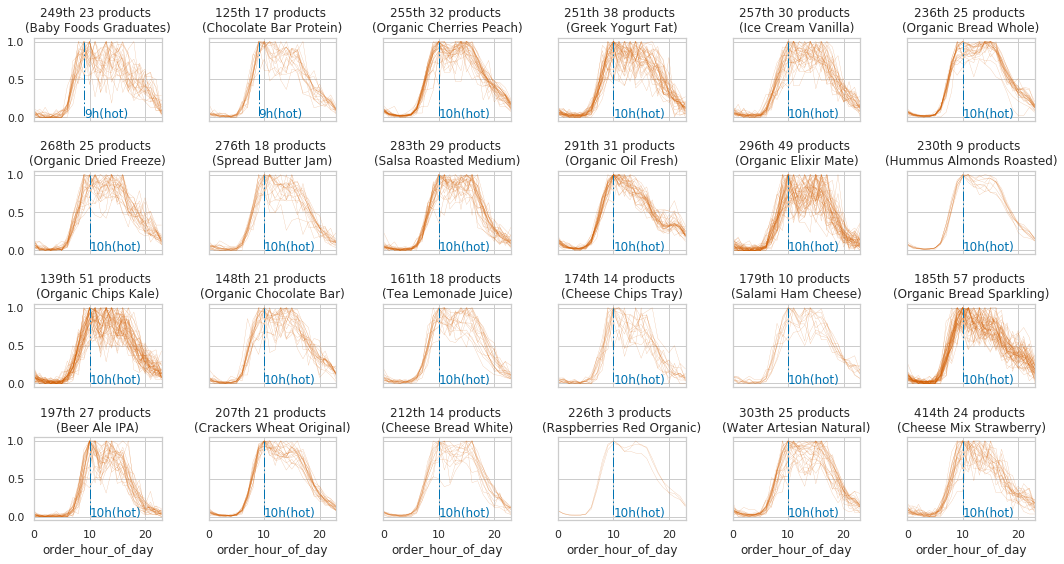

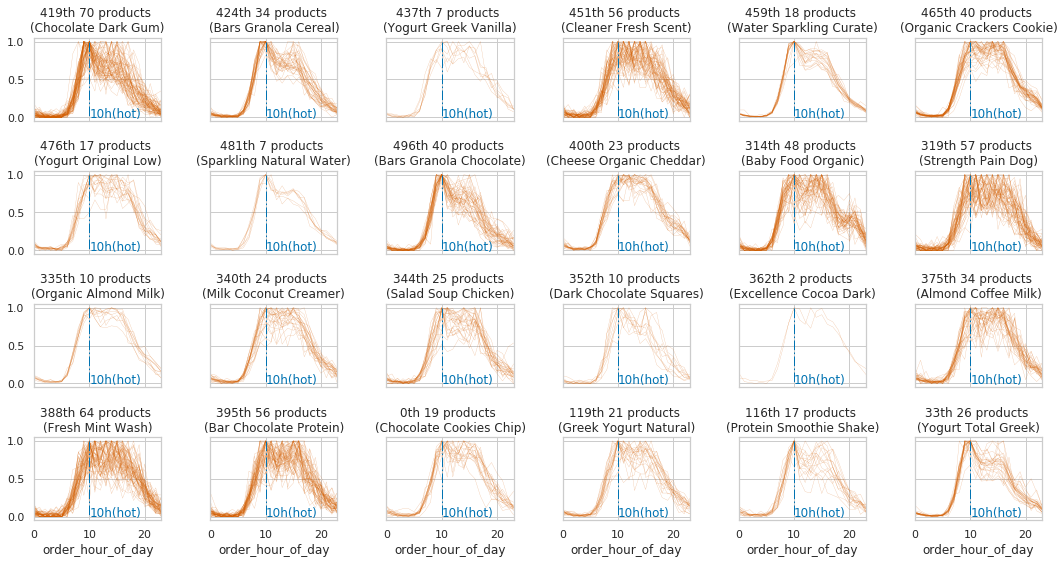

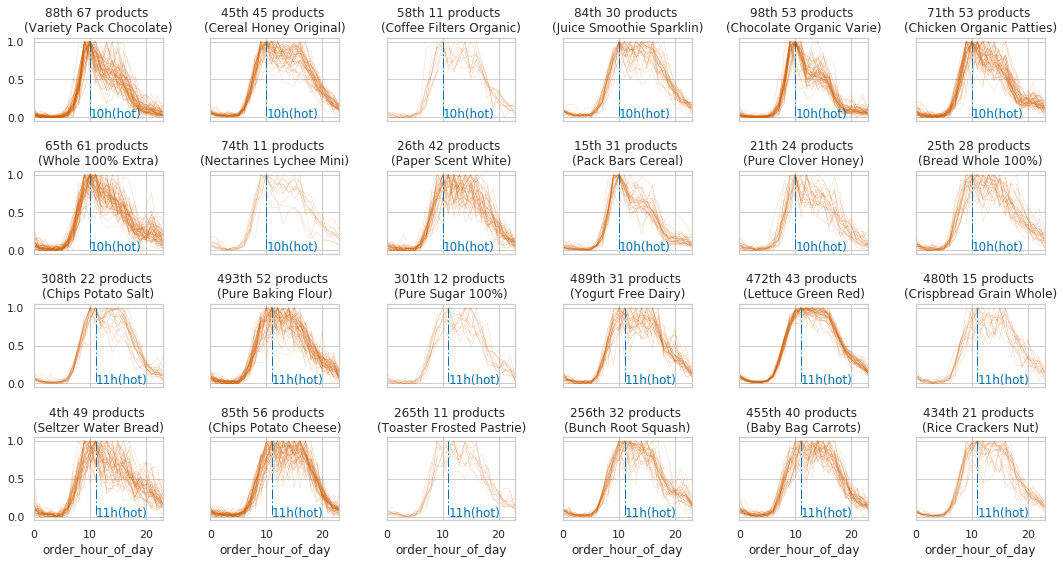

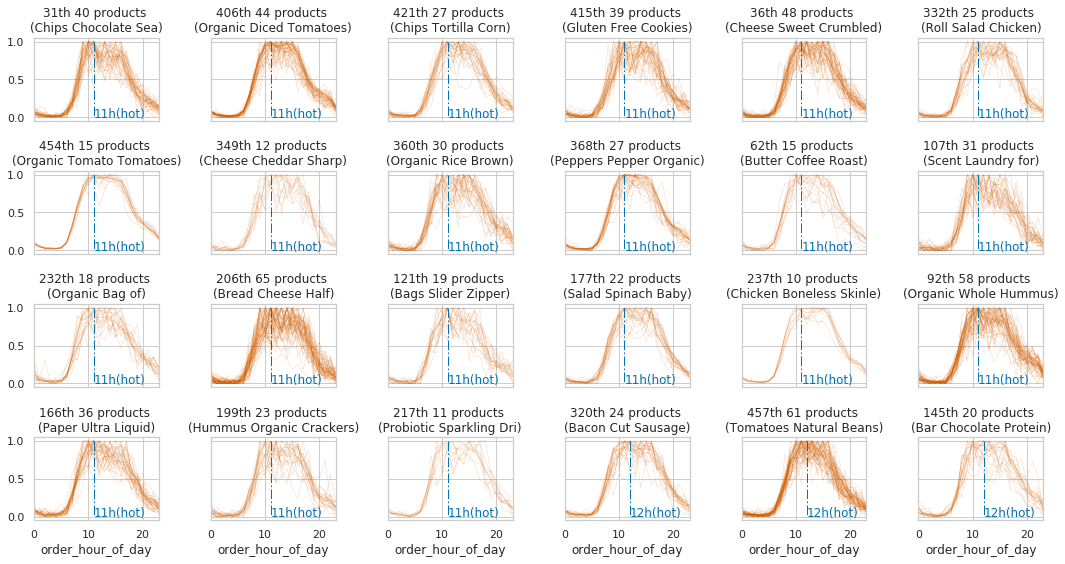

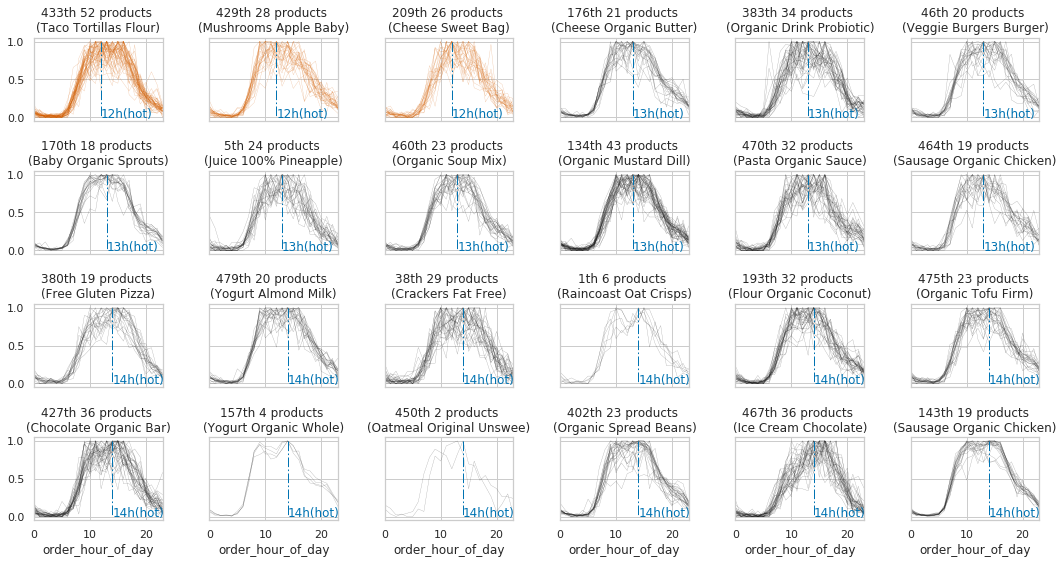

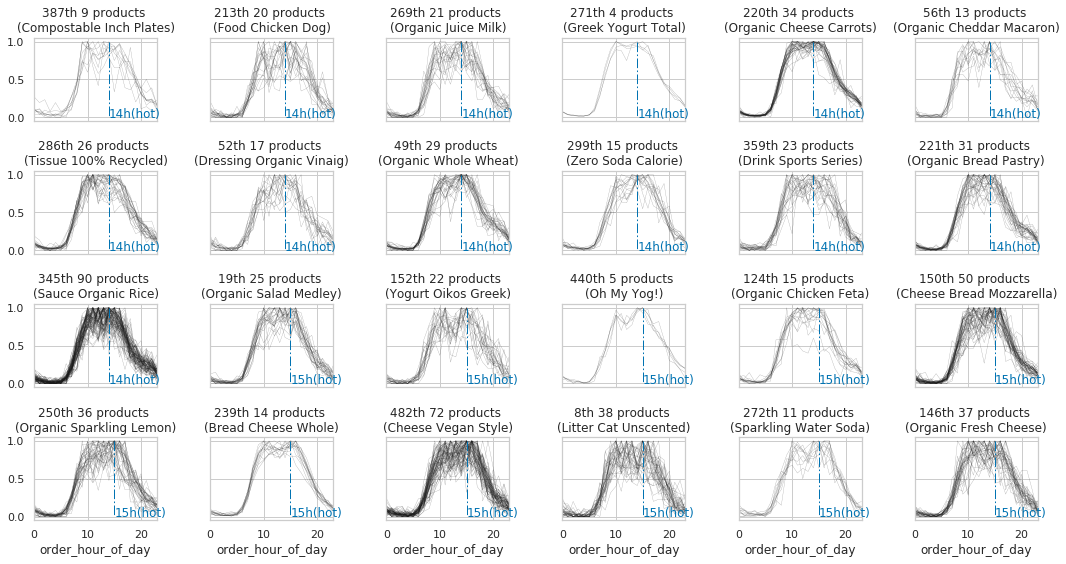

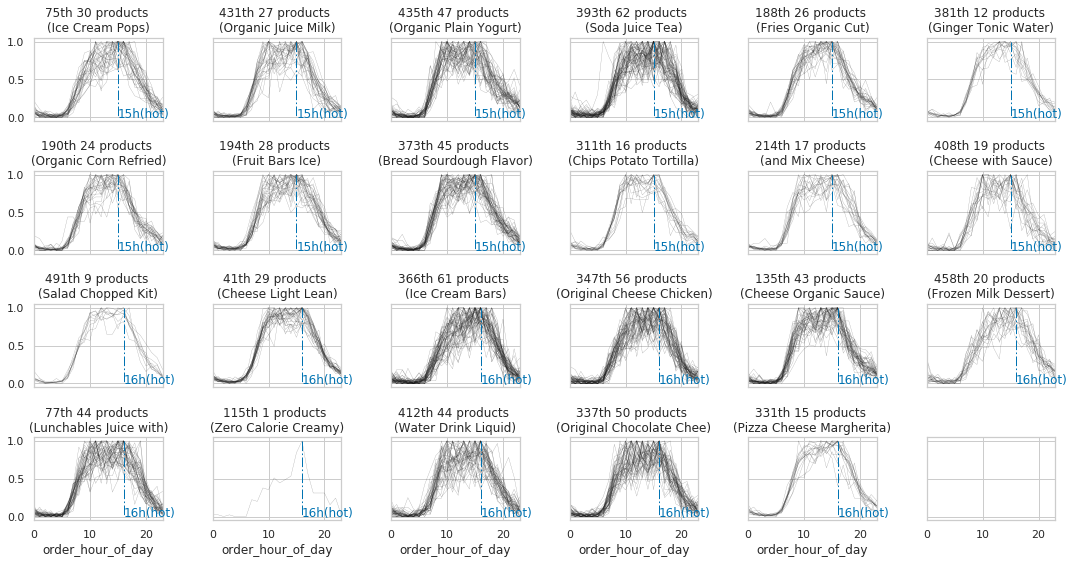

In [38]:
ncols, nrows=(6,4)
step = 3
for n in np.arange(0,500,ncols*nrows*step):
    drawHODCluster(ncols, nrows, n, step)

In [39]:
product_dow_ds = merge_order_product_ds.pivot_table(index='product_id', columns='order_dow', values='order_id', aggfunc=len, fill_value=0)

orderByHotDay = clustered_ds.merge(product_dow_ds, left_on='product_id', right_index=True)\
    .groupby('cid').sum()[np.arange(0,6)].idxmax(axis=1).sort_values().index

In [40]:
def drawDOWCluster(ncols, nrows, startClusterNumber, step):
    sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )
    week_day = "Sun Mon Tue Wed Thu Fri Sat".split()
    fig, axes = plt.subplots(ncols=ncols, nrows = nrows, figsize=(ncols*2.5,nrows*2), sharex=True, sharey=True)

    for cid, ax  in enumerate(axes.flatten()):
        cid = startClusterNumber + (cid*step)
        if cid>=500:
            break
        cid = orderByHotDay[cid]    
        product_id_list = clustered_ds[clustered_ds.cid==cid].product_id.values
        tmp_ds = product_dow_ds.loc[product_id_list].T
        hot_day = tmp_ds.sum(axis=1).argmax()
        normalized_ds =(tmp_ds/tmp_ds.max())
        normalized_ds.index = week_day
        title = "{cid}th \n({keyword})".format(cid=cid, h=hot_day,  keyword=clusterIdToKeywords[cid][:23])
        normalized_ds.plot(kind='bar', linewidth=.1, legend=False, alpha=.4, ax=ax, title=title, color='r' if hot_day in(0,6) else 'k')
        ax.plot((hot_day,hot_day),(1,0), '-.', linewidth=2, color='b')
        # ax.text(hot_day+.3,-.5,"{h}".format(h=week_day[hot_day]),color='b')
    
    fig.tight_layout()

/anaconda3/envs/ds/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


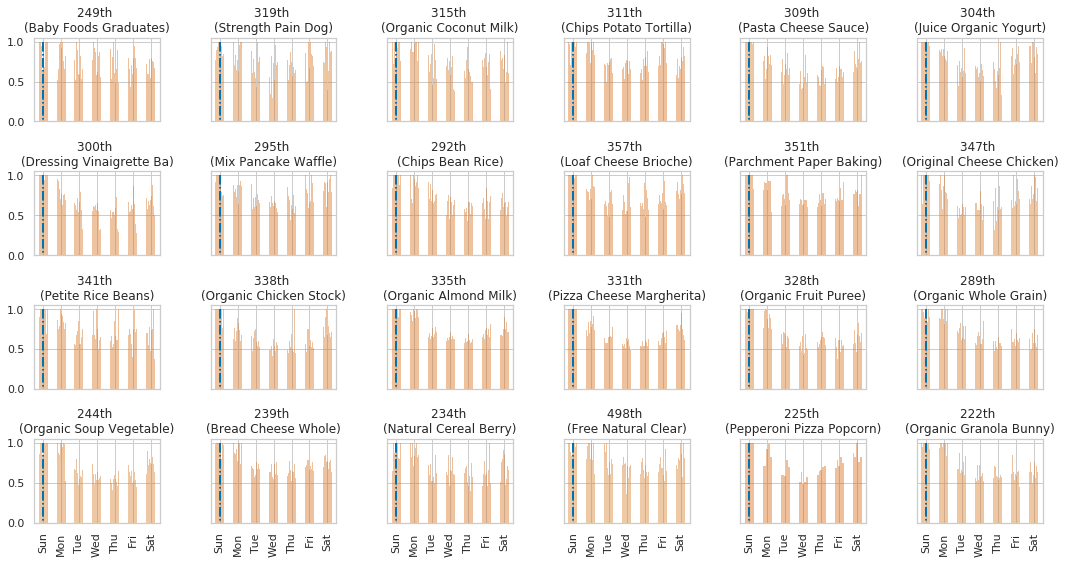

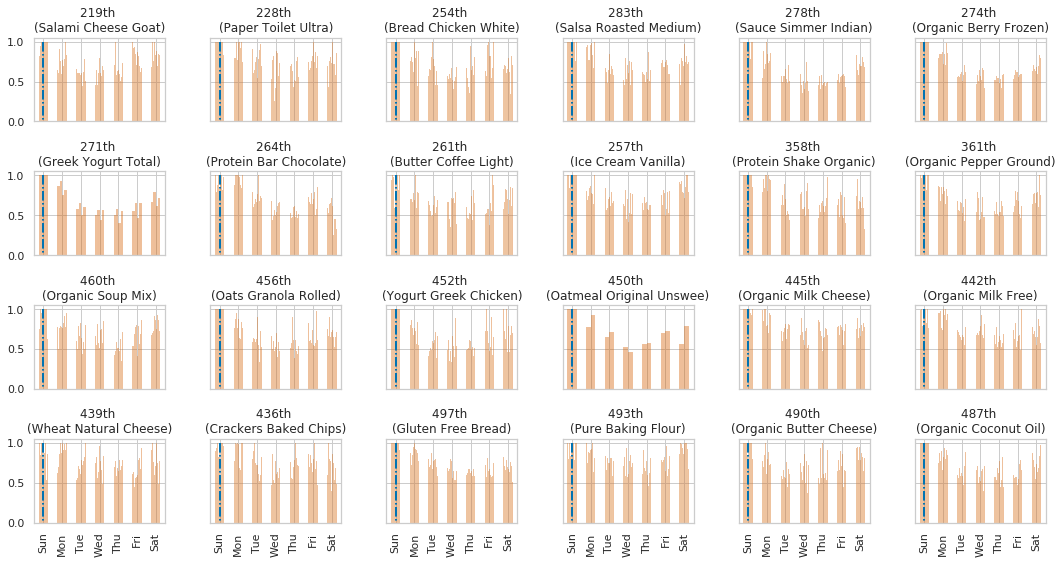

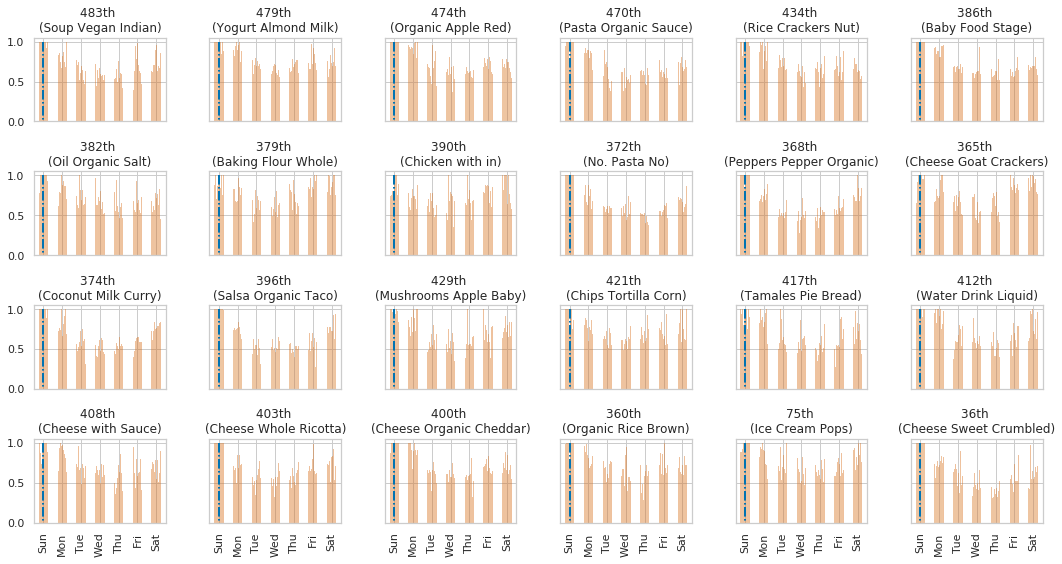

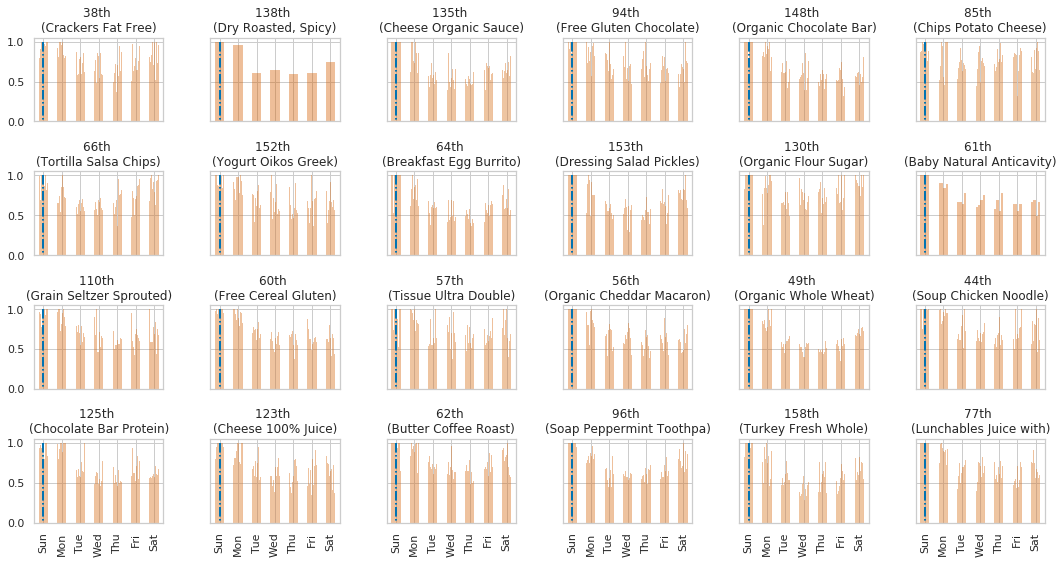

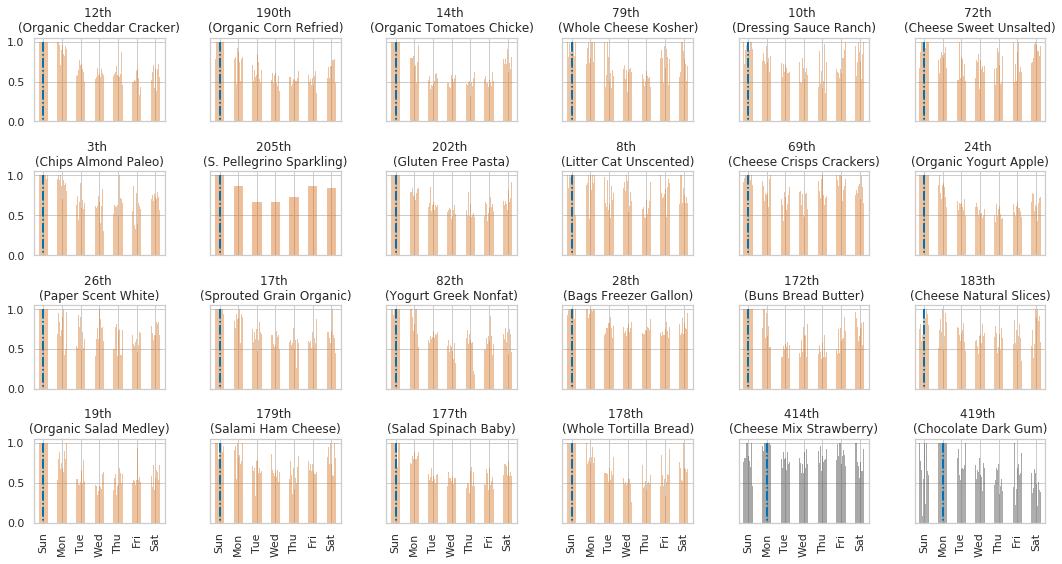

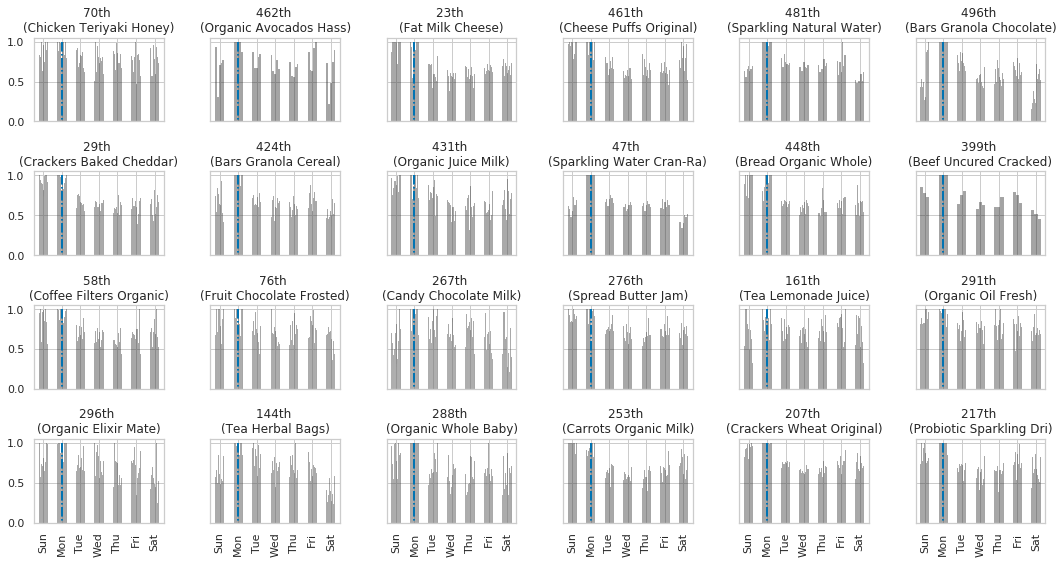

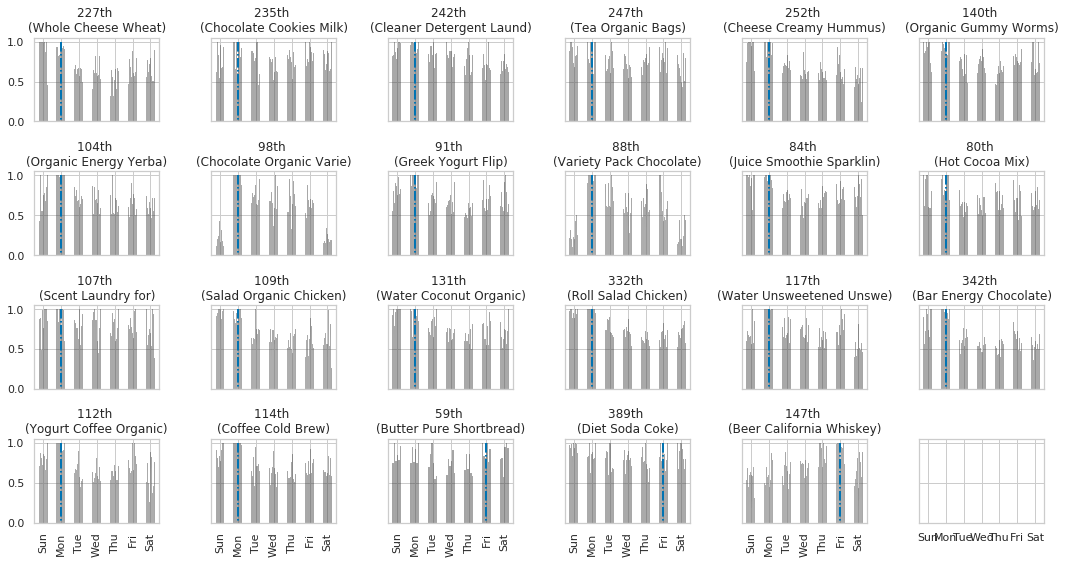

In [41]:
ncols, nrows=(6,4)
step = 3
for n in np.arange(0,500,ncols*nrows*step):
    drawDOWCluster(ncols, nrows, n, step)